In [1]:
import numpy as np
import sys, os
from imageio.v2 import imread
import pywt
from tqdm import tqdm
from skimage.restoration import denoise_wavelet, estimate_sigma
from functools import partial
# rescale_sigma=True required to silence deprecation warnings
_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)
import scipy.stats as stats
import cv2
import matplotlib.pyplot as plt

In [2]:
# =========================================================
def rescale(dat,mn,mx):
    """
    rescales an input dat between mn and mx
    """
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

##====================================
def standardize(img):
    img = np.array(img)
    #standardization using adjusted standard deviation
    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0/np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    img = rescale(img, 0, 1)
    del m, s, N

    return img

In [3]:
image= "C_1.jpg"
resolution = 0.053819445
img = cv2.imread(image)
nxx, nyy, _ = img.shape
width = max(nxx, nyy)
maxscale= width*resolution / 8

x= 0
verbose = 1

Stage 1: read image

In [4]:
im = imread(image)   # read the image straight with imread
im = np.squeeze(im)  # squeeze singleton dimensions
if len(np.shape(im))>3:
    im = im[:, :, :3]            # only keep the first 3 bands

if len(np.shape(im))==3: # if rgb, convert to grey
    im = (0.299 * im[:,:,0] + 0.5870*im[:,:,1] + 0.114*im[:,:,2]).astype('uint8')

nx,ny = np.shape(im)
if nx>ny:
    im=im.T

im = standardize(im)

Stage 2: Denoised image using default parameters of `denoise_wavelet`

In [5]:
filter=False

if filter:
    sigma_est = estimate_sigma(im, multichannel=False, average_sigmas=True)
    region = denoise_wavelet(im, multichannel=False, rescale_sigma=True,
                                method='VisuShrink', mode='soft', sigma=sigma_est*2)
else:
    region = im.copy()

original = rescale(region,0,255)

nx, ny = original.shape


Stage 3: Call cwt to get particle size distribution

In [6]:
P_og = []; M_og = []; Power = []; frequencie = []
for k in np.linspace(1,nx-1,100):
    [cfs_og, frequencies_og] = pywt.cwt(original[int(k),:], np.arange(3, np.maximum(nx,ny)/maxscale, 1),  'morl' , .5) #cmor10-8
    period_og = 1. / frequencies_og
    frequencie.append(period_og)
    power_og =(abs(cfs_og)) ** 2
    Power.append(power_og)
    power_og = np.mean(np.abs(power_og), axis=1)/(period_og**2)
    P_og.append(power_og)

    M_og.append(period_og[np.argmax(power_og)])

In [15]:
frequencie = np.array(frequencie)
Power = np.array(Power)
print(np.shape(Power)); print(np.shape(frequencie))
print(np.mean(frequencie))

# plt.plot(frequencies_og, power_og)
# plt.show()

(100, 146, 2668)
(100, 146)
46.46153846153846


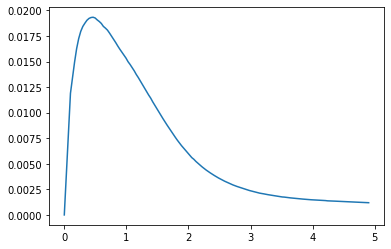

In [7]:
p_og = np.mean(np.vstack(P_og), axis=0)
p_og = np.array(p_og/np.sum(p_og))

# get real scales by multiplying by resolution (mm/pixel)
scales_og = np.array(period_og)

srt_og = np.sqrt(np.sum(p_og*((scales_og-np.mean(M_og))**2)))

# plt.plot(scales, p,'m', lw=2)

p_og = p_og+stats.norm.pdf(scales_og, np.mean(M_og), srt_og/2)
p_og = np.hstack([0,p_og])
scales_og = np.hstack([0,scales_og])
p_og = p_og/np.sum(p_og)
x_og = 0
# area-by-number to volume-by-number
r_v_og = (p_og*scales_og**x_og) / np.sum(p_og*scales_og**x_og) #volume-by-weight proportion

plt.plot((scales_og*resolution), r_v_og)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (146,) and (100, 146, 2668)

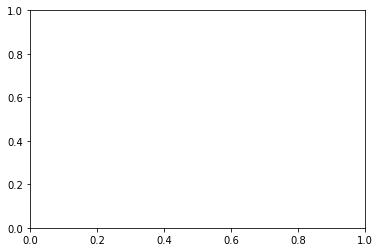

In [13]:
plt.plot(r_v_og, Power[])
plt.show()

In [ ]:
print(scales_og*resolution)

In [ ]:
print(np.sum(r_v_og[0:45]))
print(np.trapz(r_v_og[0:45], scales_og[0:45]))
print(np.sqrt(np.trapz(r_v_og[0:59], scales_og[0:59])))
print('dfew')

print(np.sum(r_v_og[59:122]))
print(np.trapz(r_v_og[45:122], scales_og[45:122]))
print(np.sqrt(np.trapz(r_v_og[45:122], scales_og[45:122])))


In [ ]:
pd_og = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_og))), np.hstack((0,scales_og)) )
data_C_og = pd_og * resolution

sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
sieve_A = [100, 100, 100, 99, 97, 90, 85, 76, 64, 44, 18, 2, 0]
percentile_C = [5, 10, 16, 25, 30, 50,  75, 84, 90, 95] 
plt.plot(data_C_og, percentile_C, marker='.')
plt.plot(sieve_open, sieve_C, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

Stage 5: Calc particle size stats

In [ ]:
pd = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
pd *= resolution
if verbose==1:
    print("d50 = "+str(pd[5]))

mnsz = np.sum(r_v*scales)
if verbose==1:
    print("mean size = "+str(mnsz))

srt = np.sqrt(np.sum(r_v*((scales-mnsz)**2)))
if verbose==1:
    print("stdev = "+str(srt))

sk = (sum(r_v*((scales-mnsz)**3)))/(100*srt**3)
if verbose==1:
    print("skewness = "+str(sk))

kurt = (sum(r_v*((scales-mnsz)**4)))/(100*srt**4)
if verbose==1:
    print("kurtosis = "+str(kurt))


Stage 6: Return a dict object of stats

In [ ]:
print( {'mean grain size': mnsz, 'grain size sorting': srt, 'grain size skewness': sk, 'grain size kurtosis': kurt, 
        'percentiles': [.05,.1,.16,.25,.3,.5,.75,.84,.9,.95], 'percentile_values': pd, 'grain size frequencies': r_v, 'grain size bins': scales})

In [ ]:
print(scales*resolution)

Testing


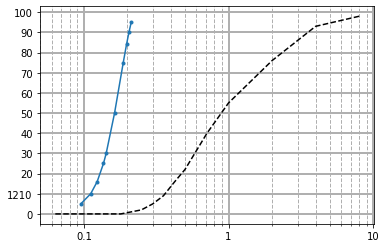

In [16]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(3 , np.maximum(nx,ny)/maxscale, 1),  'cmor10000-46', .5) 
    # np.arange(3, np.maximum(nx,ny)/maxscale, 1), 'cmor2-0.65', .5
  
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales = np.array(period)

srt = np.sqrt(np.sum(p*((scales-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales, np.mean(M), srt/2)
p = np.hstack([0,p])
scales = np.hstack([0,scales])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v = (p*scales**x) / np.sum(p*scales**x) #volume-by-weight proportion

pd = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
data_C = pd * resolution
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
sieve_A = [100, 100, 100, 99, 97, 90, 85, 76, 64, 44, 18, 2, 0]
percentile_C = [5, 10, 16, 25, 30, 50,  75, 84, 90, 95] 
plt.plot(data_C, percentile_C, marker='.')
plt.plot(sieve_open, sieve_C, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '1210', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [ ]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / .1) ,  np.maximum(nx,ny)/(width*resolution / 2), 1),  'cmor10000-0.70', .5) #cmor10-8
      
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales = np.array(period)

srt = np.sqrt(np.sum(p*((scales-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales, np.mean(M), srt/2)
p = np.hstack([0,p])
scales = np.hstack([0,scales])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v = (p*scales**x) / np.sum(p*scales**x) #volume-by-weight proportion

pd = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
data_C = pd * resolution
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
sieve_A = [100, 100, 100, 99, 97, 90, 85, 76, 64, 44, 18, 2, 0]
percentile_C = [5, 10, 16, 25, 30, 50,  75, 84, 90, 95] 
plt.plot(data_C, percentile_C, marker='.')
plt.plot(sieve_open, sieve_C, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '1210', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [ ]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / .1) ,  np.maximum(nx,ny)/(width*resolution / 2), 1),  'cmor1-0.23', 1) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales = np.array(period)

srt = np.sqrt(np.sum(p*((scales-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales, np.mean(M), srt/2)
p = np.hstack([0,p])
scales = np.hstack([0,scales])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v = (p*scales**x) / np.sum(p*scales**x) #volume-by-weight proportion

pd = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
data_C = pd * resolution
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
percentile_C = [5, 10, 16, 25, 30, 40, 50, 60, 75, 84, 90, 95] 
plt.plot(data_C, percentile_C, marker='.')
plt.plot(sieve_open, sieve_C, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

NEwe wiueB efewsf

In [ ]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / .1) ,  np.maximum(nx,ny)/(width*resolution / 1), 1),  'morl', .5) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales = np.array(period)

srt = np.sqrt(np.sum(p*((scales-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales, np.mean(M), srt/2)
p = np.hstack([0,p])
scales = np.hstack([0,scales])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v = (p*scales**x) / np.sum(p*scales**x) #volume-by-weight proportion

pd = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
data_C = pd * resolution
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
percentile_C = [5, 10, 16, 25, 30, 40, 50, 60, 75, 84, 90, 95] 
plt.plot(data_C, percentile_C, marker='.')
plt.plot(sieve_open, sieve_C, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [ ]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(3,  np.maximum(nx,ny)/(maxscale), .1),  'morl', .5) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales = np.array(period)

srt = np.sqrt(np.sum(p*((scales-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales, np.mean(M), srt/2)
p = np.hstack([0,p])
scales = np.hstack([0,scales])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v = (p*scales**x) / np.sum(p*scales**x) #volume-by-weight proportion

pd = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
data_C = pd * resolution
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
percentile_C = [5, 10, 16, 25, 30, 40, 50, 60, 75, 84, 90, 95] 
plt.plot(data_C, percentile_C, marker='.')
plt.plot(sieve_open, sieve_C, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [ ]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(3,  np.maximum(nx,ny)/(maxscale), 2),  'morl', .5) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales = np.array(period)

srt = np.sqrt(np.sum(p*((scales-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales, np.mean(M), srt/2)
p = np.hstack([0,p])
scales = np.hstack([0,scales])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v = (p*scales**x) / np.sum(p*scales**x) #volume-by-weight proportion

pd = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
data_C = pd * resolution
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
percentile_C = [5, 10, 16, 25, 30, 40, 50, 60, 75, 84, 90, 95] 
plt.plot(data_C, percentile_C, marker='.')
plt.plot(sieve_open, sieve_C, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()